# EDA and Model Pipeline for Glaucoma Detection Using VGG16
1.Data Loading and Preprocessing: Loading image files and associated labels, resizing images, and      normalizing them to prepare for model input.

2.Model Architecture: Using a pre-trained VGG16 model, adding custom layers (e.g., Dense, Dropout), and compiling the model for binary classification.

3.Training: Training the model on the processed images and labels.

4.Evaluation: Evaluating the model using metrics like accuracy, loss, confusion matrix, ROC curve, and AUC score.

5.Prediction: Making predictions on new test images to classify them as "Glaucoma" or "Non Glaucoma."

6.Visualization: Plotting accuracy, loss, and ROC curve to visualize model performance.


Shape of train_images: (3063, 224, 224, 3)
Shape of val_images: (801, 224, 224, 3)
Shape of test_images: (990, 224, 224, 3)


Epoch 1/10


96/96 [==============================] - 1509s 16s/step - loss: 0.4411 - accuracy: 0.7927 - val_loss: 0.3957 - val_accuracy: 0.8040
Epoch 2/10
96/96 [==============================] - 603s 6s/step - loss: 0.3154 - accuracy: 0.8583 - val_loss: 0.2883 - val_accuracy: 0.8826
Epoch 3/10
96/96 [==============================] - 628s 7s/step - loss: 0.2585 - accuracy: 0.8919 - val_loss: 0.2663 - val_accuracy: 0.9101
Epoch 4/10
96/96 [==============================] - 1291s 14s/step - loss: 0.2347 - accuracy: 0.9014 - val_loss: 0.2619 - val_accuracy: 0.8914
Epoch 5/10
96/96 [==============================] - 26284s 276s/step - loss: 0.2076 - accuracy: 0.9177 - val_loss: 0.2570 - val_accuracy: 0.8889
Epoch 6/10
96/96 [==============================] - 2515s 26s/step - loss: 0.2102 - accuracy: 0.9070 - val_loss: 0.2212 - val_accuracy: 0.9201
Epoch 7/10
96/9

C:\Users\aliza\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 316s 10s/step
Confusion Matrix:
 [[208  26]
 [ 42 714]]


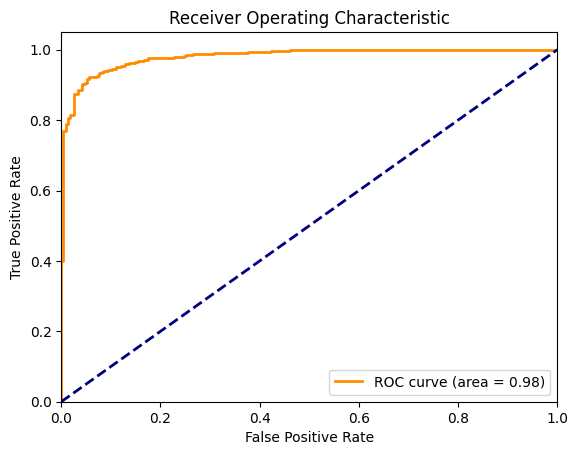

1/1 [==============================] - 0s 462ms/step


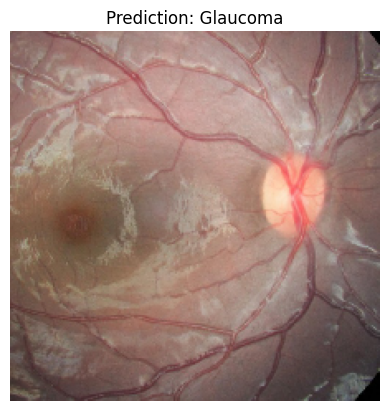

Prediction Result: Glaucoma


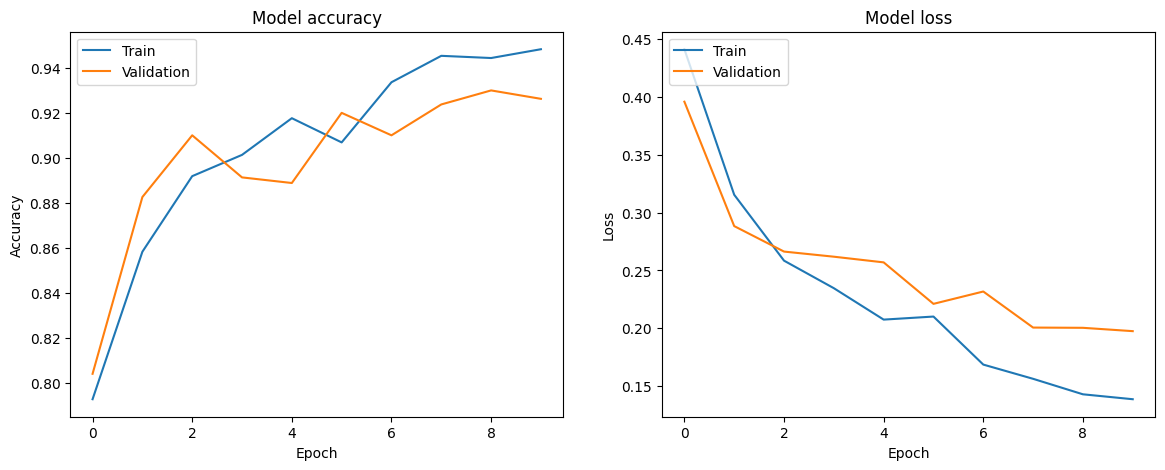

In [1]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pickle

# Define paths
train_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\train"
val_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\validation"
test_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\test"

train_csv = r"C:\Users\aliza\OneDrive\Desktop\corrected_image_labels.csv"
val_csv = r"C:\Users\aliza\OneDrive\Desktop\val_corrected_image_labels.csv"
test_csv = r"C:\Users\aliza\OneDrive\Desktop\test_corrected_image_labels.csv"

# Load CSV files
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# Ensure all labels are strings
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)
test_df['Label'] = test_df['Label'].astype(str)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on all labels to ensure consistency
all_labels = pd.concat([train_df['Label'], val_df['Label'], test_df['Label']])
label_encoder.fit(all_labels)

# Transform the labels
train_df['Label'] = label_encoder.transform(train_df['Label'])
val_df['Label'] = label_encoder.transform(val_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])

# Convert labels to float32
train_labels = train_df['Label'].astype('float32').values
val_labels = val_df['Label'].astype('float32').values
test_labels = test_df['Label'].astype('float32').values

def prepare_data(df, directory, target_size):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(directory, row['Filename'])
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0
        images.append(img)
        labels.append(row['Label'])
    return np.array(images), np.array(labels)

# Load images and labels
train_images, train_labels = prepare_data(train_df, train_dir, (224, 224))
val_images, val_labels = prepare_data(val_df, val_dir, (224, 224))
test_images, test_labels = prepare_data(test_df, test_dir, (224, 224))

print(f"Shape of train_images: {train_images.shape}")
print(f"Shape of val_images: {val_images.shape}")
print(f"Shape of test_images: {test_images.shape}")

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_images, val_labels)
)

# Save the history object
history_path = r'C:\Users\aliza\OneDrive\Desktop\model_history.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Save the model to an .h5 file
model_path = r'C:\Users\aliza\OneDrive\Desktop\glaucoma_detection_model.h5'
model.save(model_path)

# Predict on test data
test_preds = model.predict(test_images).flatten()
predicted_labels = (test_preds > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print('Confusion Matrix:\n', cm)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Function to predict glaucoma from a single image
def predict_glaucoma(image_path, model, target_size=(224, 224), threshold=0.5):
    """
    Predicts whether an image indicates glaucoma or not.

    Args:
    image_path (str): The path to the input image.
    model (tf.keras.Model): The trained model for glaucoma prediction.
    target_size (tuple): The target size to resize the input image.
    threshold (float): The decision threshold for classification.

    Returns:
    str: Prediction result ('Glaucoma' or 'Non Glaucoma').
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1] range
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    prediction = model.predict(img_array).flatten()[0]

    # Interpret the prediction
    if prediction > threshold:
        result = "Glaucoma"
    else:
        result = "Non Glaucoma"

    # Display the image with the prediction
    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    return result

# Example usage:
image_path = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\test\ng.0025.jpg"
result = predict_glaucoma(image_path, model, threshold=0.5)
print(f"Prediction Result: {result}")

# Load the history object for plotting
with open(history_path, 'rb') as file:
    history = pickle.load(file)

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()



# Evaluation of Glaucoma Detection Model Using Classification Report on Test Data

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# Define paths
test_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\test"
test_csv = r"C:\Users\aliza\OneDrive\Desktop\test_corrected_image_labels.csv"

# Load the CSV file
test_df = pd.read_csv(test_csv)

# Ensure all labels are strings
test_df['Label'] = test_df['Label'].astype(str)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on all labels to ensure consistency
all_labels = test_df['Label']
label_encoder.fit(all_labels)

# Transform the labels
test_df['Label'] = label_encoder.transform(test_df['Label'])

# Convert labels to float32
test_labels = test_df['Label'].astype('float32').values

# Function to prepare the data
def prepare_data(df, directory, target_size):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(directory, row['Filename'])
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0
        images.append(img)
        labels.append(row['Label'])
    return np.array(images), np.array(labels)

# Prepare test images and labels
test_images, test_labels = prepare_data(test_df, test_dir, (224, 224))

# Load the pre-trained model
model_path = r"C:\Users\aliza\OneDrive\Desktop\glaucoma_detection_model.h5"
model = load_model(model_path)

# Make predictions
test_preds = model.predict(test_images).flatten()
predicted_labels = (test_preds > 0.5).astype(int)

# Generate classification report
report = classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report:\n")
print(report)


31/31 [==============================] - 454s 14s/step
Classification Report:

              precision    recall  f1-score   support

    Glaucoma       0.83      0.89      0.86       234
Non-glaucoma       0.96      0.94      0.95       756

    accuracy                           0.93       990
   macro avg       0.90      0.92      0.91       990
weighted avg       0.93      0.93      0.93       990



# Batch Prediction and Visualization of Glaucoma Detection Results on Test Images

In [4]:
import os

# Define the path to the test directory
test_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\test"

# List all files in the test directory
test_images = os.listdir(test_dir)

# Calculate the number of images
num_test_images = len(test_images)

print(f"Number of images in the test dataset: {num_test_images}")

# Initialize counters
num_glaucoma_images = 0
num_non_glaucoma_images = 0

# Loop through all files and count glaucoma and non-glaucoma images
for image_name in test_images:
    if image_name.startswith('g.'):
        num_glaucoma_images += 1
    elif image_name.startswith('ng.'):
        num_non_glaucoma_images += 1

print(f"Number of images in the test dataset: {num_test_images}")
print(f"Number of glaucoma images: {num_glaucoma_images}")
print(f"Number of non-glaucoma images: {num_non_glaucoma_images}")


Number of images in the test dataset: 990
Number of images in the test dataset: 990
Number of glaucoma images: 234
Number of non-glaucoma images: 756


# Predictions on Glaucoma Detection with Image Visualization

1/1 [==============================] - 1s 912ms/step


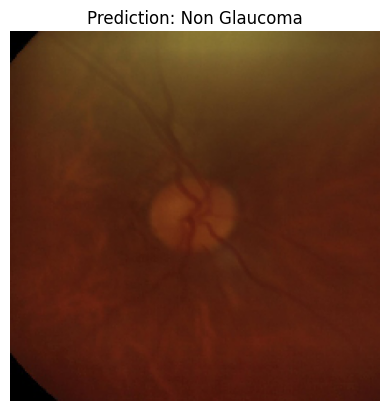

Prediction Result: Non Glaucoma


In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Define paths
model_path = r'C:\Users\aliza\OneDrive\Desktop\glaucoma_detection_model.h5'
history_path = r'C:\Users\aliza\OneDrive\Desktop\model_history.pkl'

# Load the pre-trained model
model = load_model(model_path)

# Load the history object for plotting
with open(history_path, 'rb') as file:
    history = pickle.load(file)

    
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def predict_glaucoma(image_path, model, target_size=(224, 224)):
    """
    Predicts whether an image indicates glaucoma or not.

    Args:
    image_path (str): The path to the input image.
    model (tf.keras.Model): The trained model for glaucoma prediction.
    target_size (tuple): The target size to resize the input image.

    Returns:
    str: Prediction result ('Glaucoma' or 'Non Glaucoma').
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1] range
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    prediction = model.predict(img_array).flatten()

    # Interpret the prediction
    if prediction > 0.5:
        result = "Glaucoma"
    else:
        result = "Non Glaucoma"

    # Display the image with the prediction
    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    return result

# Example usage:
image_path = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\test\ng.1368.jpg"
result = predict_glaucoma(image_path, model)
print(f"Prediction Result: {result}")


# Applying Grad-CAM for Visual Interpretation of Glaucoma Detection Model Predictions

In [16]:
pip install tf-explain



     -------------------------------------- 43.6/43.6 kB 358.2 kB/s eta 0:00:00


1/1 [==============================] - 1s 567ms/step


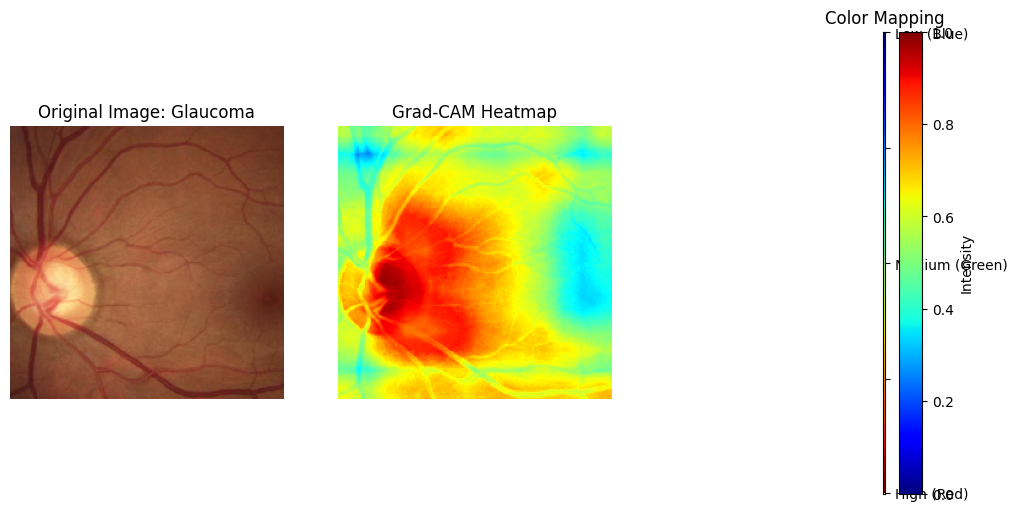

Prediction Result: Glaucoma


In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2  # Import OpenCV

# Load the saved model
model_path = r'C:\Users\aliza\OneDrive\Desktop\glaucoma_detection_model.h5'
model = tf.keras.models.load_model(model_path)

# Mapping from string colormap names to OpenCV colormap values
COLORMAPS = {
    'jet': cv2.COLORMAP_JET,
    'viridis': cv2.COLORMAP_VIRIDIS,
    'plasma': cv2.COLORMAP_PLASMA,
    'magma': cv2.COLORMAP_MAGMA,
    'inferno': cv2.COLORMAP_INFERNO
}

# Define the function to apply Grad-CAM
def apply_gradcam(image_path, model, layer_name='block5_conv3', target_size=(224, 224), threshold=0.5, colormap='jet'):
    """
    Apply Grad-CAM to visualize the regions of the image that the model focuses on.

    Args:
    - image_path (str): Path to the input image.
    - model (tf.keras.Model): The pre-trained model.
    - layer_name (str): The name of the convolutional layer to visualize.
    - target_size (tuple): The target size to resize the input image.
    - threshold (float): The decision threshold for classification.
    - colormap (str): The colormap to use for the heatmap.

    Returns:
    - str: Prediction result ('Glaucoma' or 'Non Glaucoma').
    - np.array: The Grad-CAM heatmap.
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1] range
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    prediction = model.predict(img_array).flatten()[0]

    # Determine the predicted class
    if prediction > threshold:
        result = "Glaucoma"
        class_idx = 0  # Since it's binary classification, use 0 as the class index
    else:
        result = "Non Glaucoma"
        class_idx = 0  # The same index is used regardless of the prediction

    # Generate Grad-CAM
    explainer = GradCAM()
    data = (img_array, None)
    grid = explainer.explain(data, model, class_index=class_idx, layer_name=layer_name)

    # Ensure grid is a single-channel grayscale image
    if len(grid.shape) == 3 and grid.shape[-1] == 3:
        grid = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

    # Convert heatmap to the correct colormap
    if colormap in COLORMAPS:
        grid = cv2.applyColorMap((grid * 255).astype("uint8"), COLORMAPS[colormap])

    # Display the image and the heatmap with color bar
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image: {result}")
    plt.axis('off')

    # Grad-CAM Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(grid)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Add color bar
    plt.subplot(1, 3, 3)
    plt.imshow(np.linspace(0, 1, 256).reshape(256, 1), cmap=colormap)
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.colorbar(label='Intensity', orientation='vertical')
    plt.xticks([])
    plt.yticks([0, 64, 128, 192, 255], ['Low (Blue)', ' ', 'Medium (Green)', ' ', 'High (Red)'])
    plt.title("Color Mapping")

    plt.show()

    return result, grid

# Example usage:
image_path = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\test\g.0069.jpg" 
result, gradcam_heatmap = apply_gradcam(image_path, model, layer_name='block5_conv3', threshold=0.5, colormap='jet')
print(f"Prediction Result: {result}")


1/1 [==============================] - 0s 466ms/step


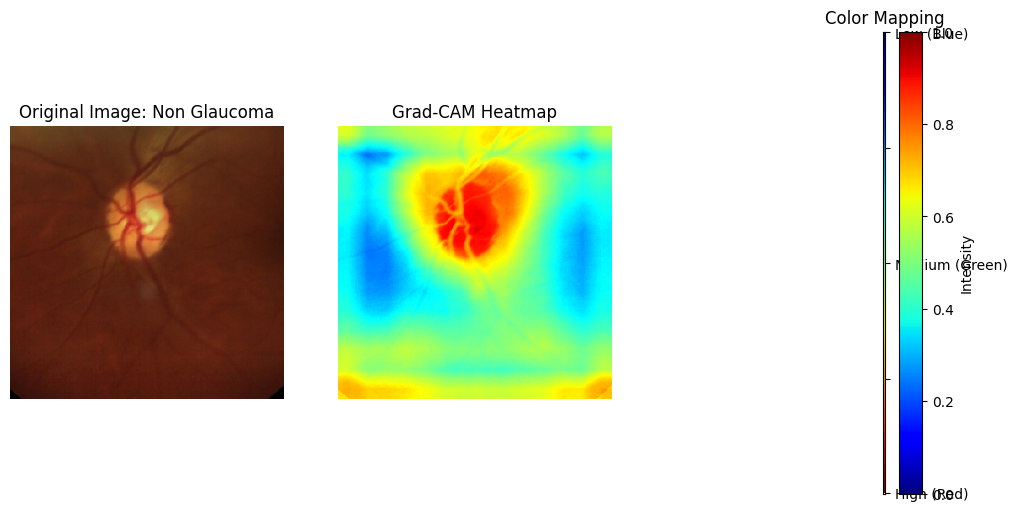

Prediction Result: Non Glaucoma


In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2  # Import OpenCV

# Load the saved model
model_path = r'C:\Users\aliza\OneDrive\Desktop\glaucoma_detection_model.h5'
model = tf.keras.models.load_model(model_path)

# Mapping from string colormap names to OpenCV colormap values
COLORMAPS = {
    'jet': cv2.COLORMAP_JET,
    'viridis': cv2.COLORMAP_VIRIDIS,
    'plasma': cv2.COLORMAP_PLASMA,
    'magma': cv2.COLORMAP_MAGMA,
    'inferno': cv2.COLORMAP_INFERNO
}

# Define the function to apply Grad-CAM
def apply_gradcam(image_path, model, layer_name='block5_conv3', target_size=(224, 224), threshold=0.5, colormap='jet'):
    """
    Apply Grad-CAM to visualize the regions of the image that the model focuses on.

    Args:
    - image_path (str): Path to the input image.
    - model (tf.keras.Model): The pre-trained model.
    - layer_name (str): The name of the convolutional layer to visualize.
    - target_size (tuple): The target size to resize the input image.
    - threshold (float): The decision threshold for classification.
    - colormap (str): The colormap to use for the heatmap.

    Returns:
    - str: Prediction result ('Glaucoma' or 'Non Glaucoma').
    - np.array: The Grad-CAM heatmap.
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1] range
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    prediction = model.predict(img_array).flatten()[0]

    # Determine the predicted class
    if prediction > threshold:
        result = "Glaucoma"
        class_idx = 0  # Since it's binary classification, use 0 as the class index
    else:
        result = "Non Glaucoma"
        class_idx = 0  # The same index is used regardless of the prediction

    # Generate Grad-CAM
    explainer = GradCAM()
    data = (img_array, None)
    grid = explainer.explain(data, model, class_index=class_idx, layer_name=layer_name)

    # Ensure grid is a single-channel grayscale image
    if len(grid.shape) == 3 and grid.shape[-1] == 3:
        grid = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

    # Convert heatmap to the correct colormap
    if colormap in COLORMAPS:
        grid = cv2.applyColorMap((grid * 255).astype("uint8"), COLORMAPS[colormap])

    # Display the image and the heatmap with color bar
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image: {result}")
    plt.axis('off')

    # Grad-CAM Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(grid)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    # Add color bar
    plt.subplot(1, 3, 3)
    plt.imshow(np.linspace(0, 1, 256).reshape(256, 1), cmap=colormap)
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.colorbar(label='Intensity', orientation='vertical')
    plt.xticks([])
    plt.yticks([0, 64, 128, 192, 255], ['Low (Blue)', ' ', 'Medium (Green)', ' ', 'High (Red)'])
    plt.title("Color Mapping")

    plt.show()

    return result, grid

# Example usage:
image_path = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\test\ng.0355.jpg"  #ng.0004
result, gradcam_heatmap = apply_gradcam(image_path, model, layer_name='block5_conv3', threshold=0.5, colormap='jet')
print(f"Prediction Result: {result}")


# Interactive Glaucoma Detection Tool

In [1]:


import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import gradio as gr

# Load the saved model
model_path = r'C:\Users\aliza\OneDrive\Desktop\glaucoma_detection_model.h5'
model = load_model(model_path)

def grad_cam(model, img_array, layer_name='block5_conv3'):
    """
    Compute Grad-CAM heatmap for a given image and model.
    """
    try:
        # Create a model that outputs the activations of the specified layer and the final predictions
        grad_model = tf.keras.models.Model(
            [model.inputs], 
            [model.get_layer(layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            # Forward pass
            conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
            loss = predictions[:, 0]

        # Compute gradients
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Apply pooled gradients to convolutional outputs
        conv_outputs = conv_outputs[0].numpy()
        cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)
        for i, w in enumerate(pooled_grads):
            cam += w * conv_outputs[:, :, i]

        # Normalize and resize the heatmap
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        cam = cv2.resize(cam, (img_array.shape[1], img_array.shape[0]))

        return cam
    except Exception as e:
        print(f"Error in Grad-CAM: {e}")
        return np.zeros((img_array.shape[0], img_array.shape[1]))

def predict(image):
    """
    Predict glaucoma and generate Grad-CAM heatmap for the input image.
    """
    try:
        # Preprocess the image
        img_array = img_to_array(image) / 255.0
        img_array_resized = cv2.resize(img_array, (224, 224))  # Resize image to model input size

        # Predict using the model
        prediction = model.predict(np.expand_dims(img_array_resized, axis=0)).flatten()[0]

        # Generate the Grad-CAM heatmap
        heatmap = grad_cam(model, img_array_resized, 'block5_conv3')

        # Convert heatmap to RGB format
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay the heatmap on the original image
        img_array_resized = np.uint8(img_array_resized * 255)  # Ensure correct type
        overlay = cv2.addWeighted(img_array_resized, 0.6, heatmap, 0.4, 0)
        overlay_image = tf.keras.preprocessing.image.array_to_img(overlay)

        # Determine prediction label
        result = "Glaucoma" if prediction > 0.5 else "Non Glaucoma"

        return overlay_image, result
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None, "Error in prediction"

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(label="Grad-CAM Heatmap"), gr.Textbox(label="Prediction")],
    title="Glaucoma Detection with Grad-CAM",
    description="Upload an eye image to get a glaucoma prediction and see the Grad-CAM heatmap."
)

# Launch the interface
interface.launch(share=True)






Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://d38a8eb08b69c7afb7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 126ms/step


In [2]:
from tensorflow.keras.models import load_model

# Load the model
model_path = r'C:\Users\aliza\OneDrive\Desktop\glaucoma_detection_model.h5'
model = load_model(model_path)

# Print the model summary
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [2]:
import os

def count_images(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Define directories
train_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\train"
val_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\validation"
test_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\test"

# Count images
train_size = count_images(train_dir)
test_size = count_images(test_dir)
validation_size = count_images(val_dir)

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Validation size: {validation_size}")


Train size: 3063
Test size: 990
Validation size: 801


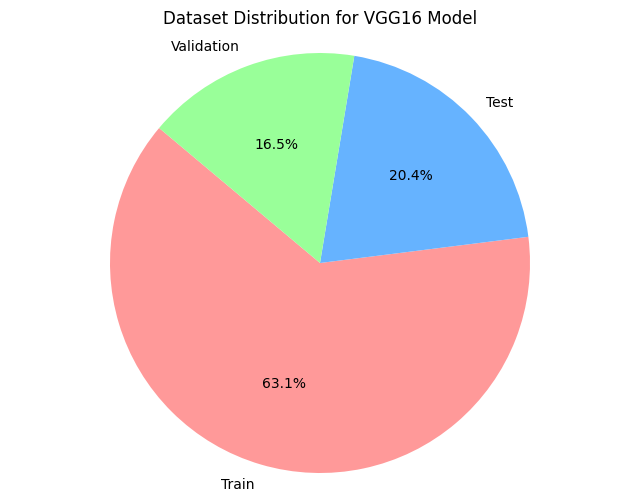

In [3]:
import matplotlib.pyplot as plt

# Dataset sizes (use counts from above)
sizes = [train_size, test_size, validation_size]
labels = ['Train', 'Test', 'Validation']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Dataset Distribution for VGG16 Model')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()


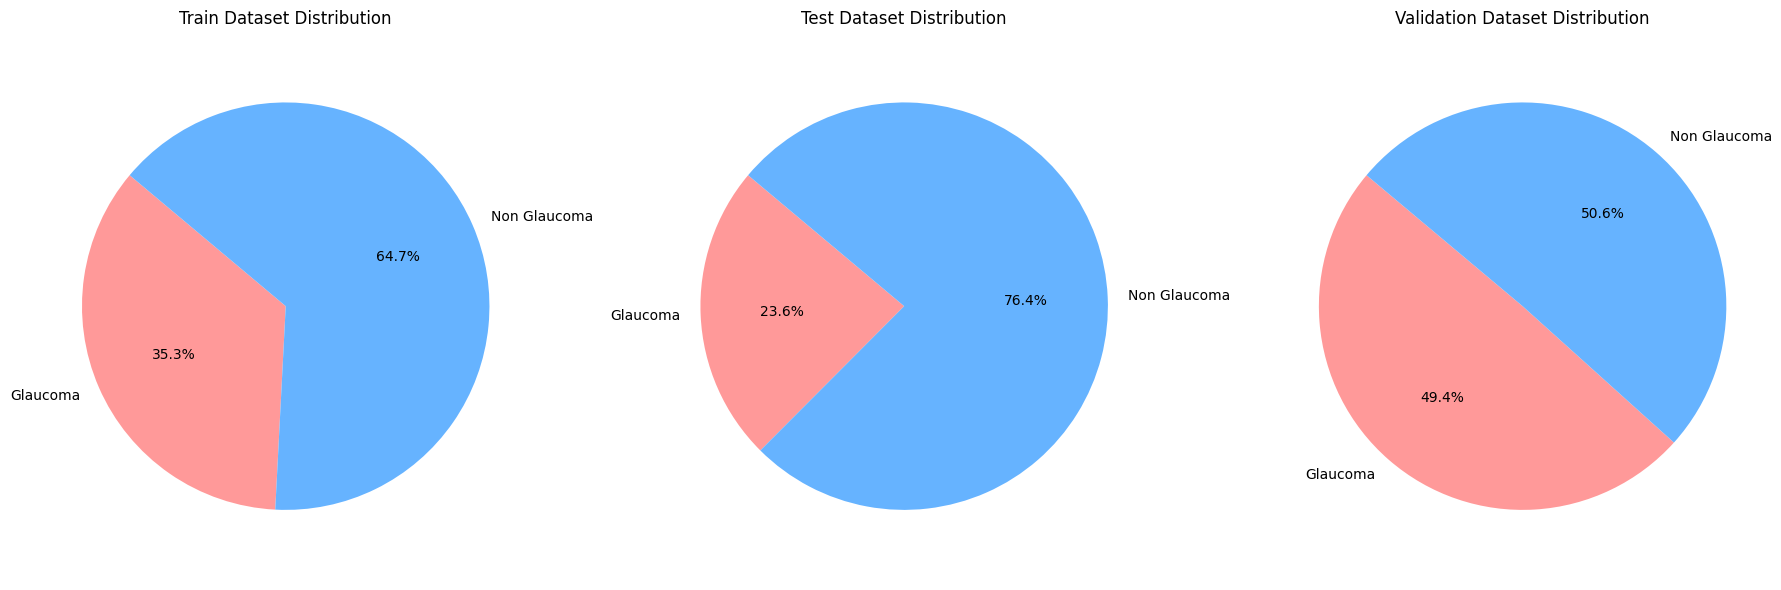

In [11]:
import matplotlib.pyplot as plt

# Computed counts
train_glaucoma = 1081
train_non_glaucoma = 3063 - 1081
test_glaucoma = 234
test_non_glaucoma = 990 - 234
validation_glaucoma = 396
validation_non_glaucoma = 801 - 396

def plot_pie_chart(ax, glaucoma_count, non_glaucoma_count, title):
    sizes = [glaucoma_count, non_glaucoma_count] if non_glaucoma_count > 0 else [glaucoma_count]
    labels = ['Glaucoma', 'Non Glaucoma'] if non_glaucoma_count > 0 else ['Glaucoma']
    colors = ['#ff9999', '#66b3ff'] if non_glaucoma_count > 0 else ['#ff9999']
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    ax.set_title(title)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create subplots for pie charts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot pie charts for each dataset
plot_pie_chart(axs[0], train_glaucoma, train_non_glaucoma, 'Train Dataset Distribution')
plot_pie_chart(axs[1], test_glaucoma, test_non_glaucoma, 'Test Dataset Distribution')
plot_pie_chart(axs[2], validation_glaucoma, validation_non_glaucoma, 'Validation Dataset Distribution')

# Show all pie charts
plt.tight_layout()
plt.show()


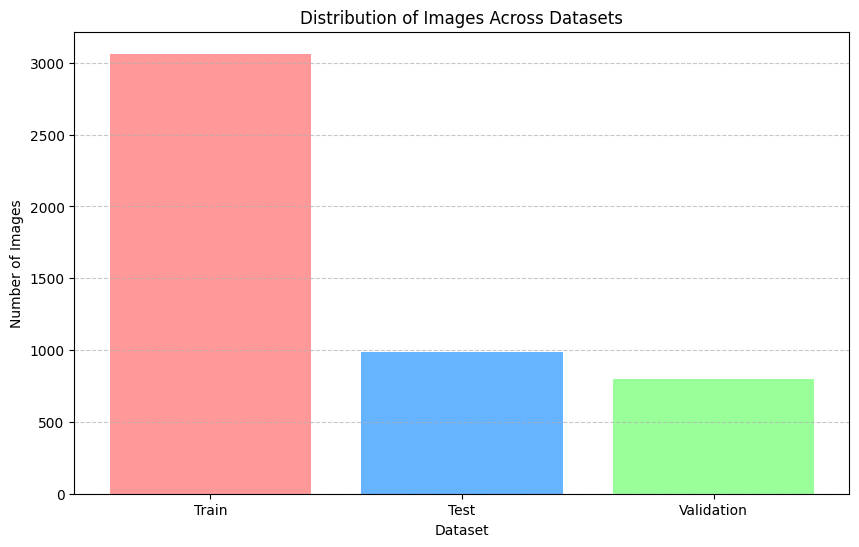

In [12]:
import matplotlib.pyplot as plt

# Dataset sizes
dataset_names = ['Train', 'Test', 'Validation']
dataset_sizes = [3063, 990, 801]

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(dataset_names, dataset_sizes, color=['#ff9999', '#66b3ff', '#99ff99'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Datasets')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Shape of train_images: (3063, 224, 224, 3)
Shape of val_images: (801, 224, 224, 3)
Shape of test_images: (990, 224, 224, 3)
31/31 [==============================] - 122s 4s/step


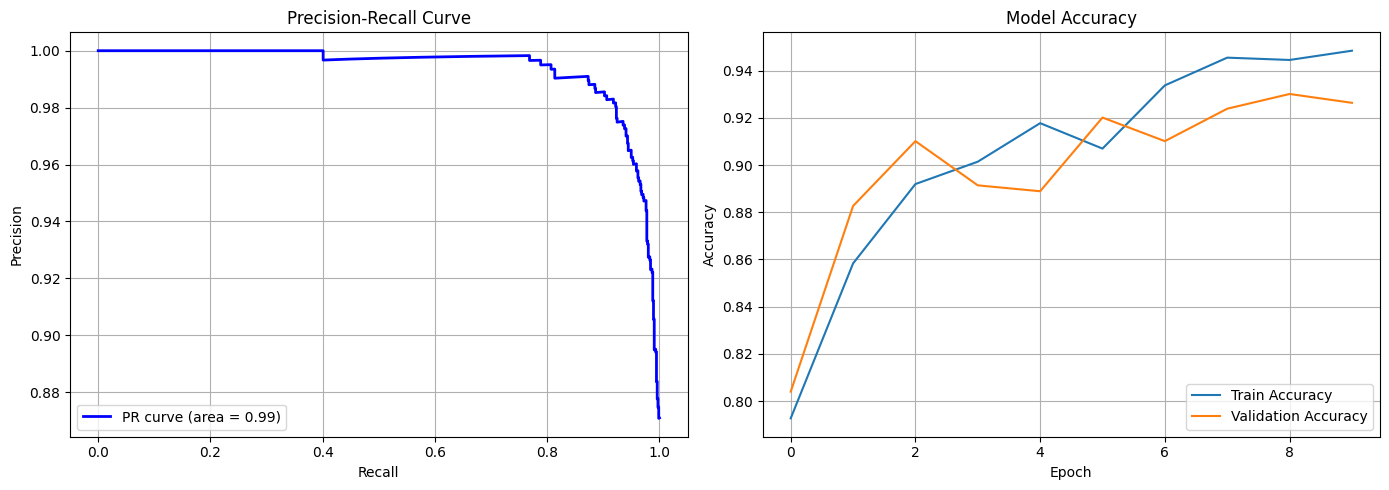

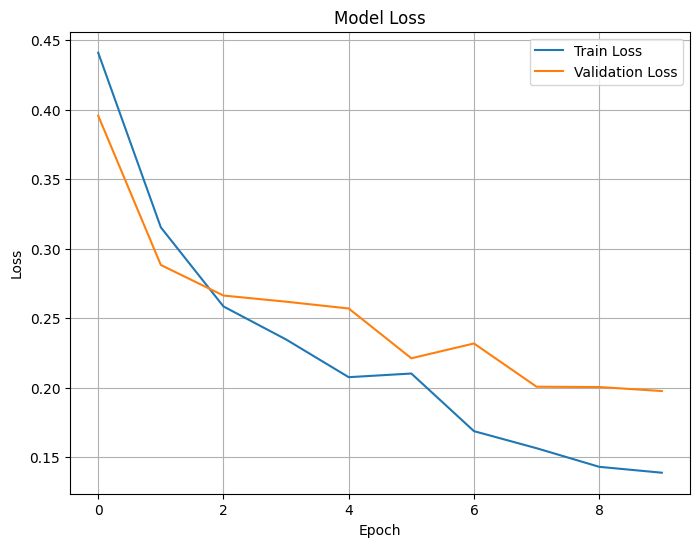

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from tensorflow.keras.models import load_model
import pickle
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pickle

# Define paths
train_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\train"
val_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\validation"
test_dir = r"C:\Users\aliza\OneDrive\Desktop\excel,csv\archive (4)\LAG\test"

train_csv = r"C:\Users\aliza\OneDrive\Desktop\corrected_image_labels.csv"
val_csv = r"C:\Users\aliza\OneDrive\Desktop\val_corrected_image_labels.csv"
test_csv = r"C:\Users\aliza\OneDrive\Desktop\test_corrected_image_labels.csv"

# Load CSV files
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# Ensure all labels are strings
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)
test_df['Label'] = test_df['Label'].astype(str)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on all labels to ensure consistency
all_labels = pd.concat([train_df['Label'], val_df['Label'], test_df['Label']])
label_encoder.fit(all_labels)

# Transform the labels
train_df['Label'] = label_encoder.transform(train_df['Label'])
val_df['Label'] = label_encoder.transform(val_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])

# Convert labels to float32
train_labels = train_df['Label'].astype('float32').values
val_labels = val_df['Label'].astype('float32').values
test_labels = test_df['Label'].astype('float32').values

def prepare_data(df, directory, target_size):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(directory, row['Filename'])
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0
        images.append(img)
        labels.append(row['Label'])
    return np.array(images), np.array(labels)

# Load images and labels
train_images, train_labels = prepare_data(train_df, train_dir, (224, 224))
val_images, val_labels = prepare_data(val_df, val_dir, (224, 224))
test_images, test_labels = prepare_data(test_df, test_dir, (224, 224))

print(f"Shape of train_images: {train_images.shape}")
print(f"Shape of val_images: {val_images.shape}")
print(f"Shape of test_images: {test_images.shape}")


# Path to your saved model and history
model_path = r'C:\Users\aliza\OneDrive\Desktop\glaucoma_detection_model.h5'
history_path = r'C:\Users\aliza\OneDrive\Desktop\model_history.pkl'

# Load the saved model
model = load_model(model_path)

# Load the saved history
with open(history_path, 'rb') as file:
    history = pickle.load(file)

# Assuming test_images and test_labels are already prepared
# Load images and labels
train_images, train_labels = prepare_data(train_df, train_dir, (224, 224))
val_images, val_labels = prepare_data(val_df, val_dir, (224, 224))
test_images, test_labels = prepare_data(test_df, test_dir, (224, 224))

# Predict on test data to get predicted probabilities
test_preds_proba = model.predict(test_images).flatten()

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, test_preds_proba)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='b', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot training & validation loss values in a new figure
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
